<a href="https://colab.research.google.com/github/leticiabalbi/Projeto-SUPER/blob/main/Classifica%C3%A7%C3%A3o_de_doen%C3%A7as_respirat%C3%B3rias_em_auscultas_pulmonares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from os import listdir     
import pandas as pd 
import numpy as np
import random
import math
import librosa
import librosa.display
from scipy.signal import butter, lfilter
!pip install -q tensorflow-io
import tensorflow_io as tfio
from sklearn import preprocessing
import tensorflow as tf
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.layers import Input, Lambda
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
!pip install -U tensorflow-addons
import tensorflow_addons as tfa
from sklearn.manifold import TSNE
import seaborn as sns; sns.set()
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Carregando a base de dados

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xPucswVV0cBpWCcMNyCahznH6wRe3Oza' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xPucswVV0cBpWCcMNyCahznH6wRe3Oza" -O Respiratory_Sound_Database.tar && rm -rf /tmp/cookies.txt
!tar -C ./ -xvf './Respiratory_Sound_Database.tar'

In [4]:
files_path = './Respiratory_Sound_Database/audio_and_txt_files/'          #caminho das amostras de áudio e suas anotações
diagnosis_path = './Respiratory_Sound_Database/patient_diagnosis.csv'     #caminho do diagnóstico de cada paciente

# Dataframe das informações necessárias para a realização do experimento

In [5]:
#Função que retorna o nome de todos os arquivos de uma extensão presentes em um diretório
def files_from_path(path, extension):
  # path: diretório em que se deseja buscar os arquivos 
  # extension: extensão dos arquivos
  files = []
  for file in listdir(path):
    if file.endswith(extension):
      files.append(file)
  return sorted(files)

#Função que retorna um vetor com as informações contidas no nome de uma amostra de áudio
def tokenize_file(filename):
    # filename: nome da amostra de áudio
    return filename.split('_')

In [6]:
annotations = files_from_path(files_path, ".txt")   
files_ = []

for txt_file in annotations:
    df_annotations = pd.read_csv(files_path + txt_file, sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    txt_file = txt_file[:-4]
    df_annotations['wav_file'] = txt_file + '.wav'
    df_annotations['patient_number'] = tokenize_file(txt_file)[0]
    df_annotations['position'] = tokenize_file(txt_file)[2]
    df_annotations['channel'] = tokenize_file(txt_file)[3]
    df_annotations['device'] = tokenize_file(txt_file)[4]
    files_.append(df_annotations)

df_annotations = pd.concat(files_).reset_index(drop=True)
df_annotations['patient_number'] = df_annotations['patient_number'].astype('float64')

col_names= ['patient_number', 'diagnosis']    
df_diag = pd.read_csv(diagnosis_path, sep=",", header=None, names=col_names)
df_annotations = pd.merge(df_annotations, df_diag, on = 'patient_number')

df_annotations.head(1000)

,start,end,crackles,wheezes,wav_file,patient_number,position,channel,device,diagnosis
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron.wav,101.0,Al,sc,Meditron,URTI
...,...,...,...,...,...,...,...,...,...,...
995,13.202,15.384,1,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy
996,15.384,17.167,0,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy
997,17.167,19.421,1,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy
998,19.421,19.934,0,0,127_1b1_Ar_sc_Meditron.wav,127.0,Ar,sc,Meditron,Healthy


# Remoção das classes Asthma e LRTI

In [7]:
# Função que imprime a quantidade de pacientes que cada classe possui
def patient_per_class(df):
  print("Asthma: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'Asthma']['patient_number']))))
  print("Bronchiolitis: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'Bronchiolitis']['patient_number']))))
  print("Bronchiectasis: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'Bronchiectasis']['patient_number']))))
  print("COPD: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'COPD']['patient_number']))))
  print("Healthy: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'Healthy']['patient_number']))))
  print("LRTI: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'LRTI']['patient_number']))))
  print("Pneumonia: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'Pneumonia']['patient_number']))))
  print("URTI: "+ str(len(np.unique(df.loc[df['diagnosis'] == 'URTI']['patient_number']))))
  print(" ")

In [8]:
patient_per_class(df_annotations)

Asthma: 1
Bronchiolitis: 6
Bronchiectasis: 7
COPD: 64
Healthy: 26
LRTI: 2
Pneumonia: 6
URTI: 14
 


In [9]:
df_annotations = df_annotations[(df_annotations['diagnosis'] != 'Asthma') & (df_annotations['diagnosis'] != 'LRTI')]
df_annotations = df_annotations.reset_index(drop=True)

# Divisão da base em treino, teste e validação

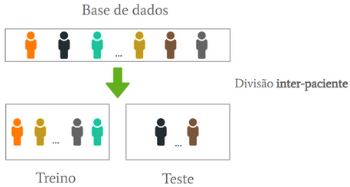

In [46]:
# O intuito é, que para cada base (treino, teste e validação), a quantidade de pacientes por classe seja proporcional
train_size_per_class = 70             #Treino = 70% dos pacientes de cada classe        
test_size_per_class = 15              #Teste =  15% dos pacientes de cada classe
                                      #Validação = 15% dos pacientes de cada classe

# Para cada classe forma um vetor contendo o id de cada paciente 
patients_Bronchiolitis = np.unique(df_annotations.loc[df_annotations['diagnosis'] == 'Bronchiolitis']['patient_number'])
patients_Bronchiectasis = np.unique(df_annotations.loc[df_annotations['diagnosis'] == 'Bronchiectasis']['patient_number'])
patients_COPD = np.unique(df_annotations.loc[df_annotations['diagnosis'] == 'COPD']['patient_number'])
patients_Healthy = np.unique(df_annotations.loc[df_annotations['diagnosis'] == 'Healthy']['patient_number'])
patients_Pneumonia = np.unique(df_annotations.loc[df_annotations['diagnosis'] == 'Pneumonia']['patient_number'])
patients_URTI = np.unique(df_annotations.loc[df_annotations['diagnosis'] == 'URTI']['patient_number'])

#Embaralha aleatoriamente o vetor do id dos pacientes
random.Random(3).shuffle(patients_Bronchiolitis)
random.Random(3).shuffle(patients_Bronchiectasis)
random.Random(3).shuffle(patients_COPD)
random.Random(3).shuffle(patients_Healthy)
random.Random(3).shuffle(patients_Pneumonia)
random.Random(3).shuffle(patients_URTI)

#Define a quantidade de pacientes que cada classe irá ter no treino
train_Bronchiolitis = (train_size_per_class*len(patients_Bronchiolitis))//100
train_Bronchiectasis = (train_size_per_class*len(patients_Bronchiectasis))//100
train_COPD = (train_size_per_class*len(patients_COPD))//100
train_Healthy = (train_size_per_class*len(patients_Healthy))//100
train_Pneumonia = (train_size_per_class*len(patients_Pneumonia))//100
train_URTI = (train_size_per_class*len(patients_URTI))//100

#Define a quantidade de pacientes que cada classe irá ter no teste
test_Bronchiolitis = math.ceil((test_size_per_class*len(patients_Bronchiolitis))/100)
test_Bronchiectasis = (test_size_per_class*len(patients_Bronchiectasis))//100
test_COPD = (test_size_per_class*len(patients_COPD))//100
test_Healthy = (test_size_per_class*len(patients_Healthy))//100
test_Pneumonia = ((test_size_per_class*len(patients_Pneumonia))//100) + 1
test_URTI = (test_size_per_class*len(patients_URTI))//100

#Cria dataframe de treino
df_train = df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiolitis[0]]
for i in range(1,train_Bronchiolitis):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiolitis[i]])
for i in range(train_Bronchiectasis):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiectasis[i]])
for i in range(train_COPD):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_COPD[i]])
for i in range(train_Healthy):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_Healthy[i]])
for i in range(train_Pneumonia):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_Pneumonia[i]])
for i in range(train_URTI):
  df_train = df_train.append(df_annotations.loc[df_annotations['patient_number'] == patients_URTI[i]])

#Cria dataframe de teste
df_test = df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiolitis[train_Bronchiolitis]]
for i in range(train_Bronchiolitis+1,train_Bronchiolitis+test_Bronchiolitis):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiolitis[i]])
for i in range(train_Bronchiectasis,train_Bronchiectasis+test_Bronchiectasis):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiectasis[i]])
for i in range(train_COPD,train_COPD+test_COPD):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_COPD[i]])
for i in range(train_Healthy,train_Healthy+test_Healthy):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_Healthy[i]])
for i in range(train_Pneumonia,train_Pneumonia+test_Pneumonia):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_Pneumonia[i]])
for i in range(train_URTI,train_URTI+test_URTI):
  df_test = df_test.append(df_annotations.loc[df_annotations['patient_number'] == patients_URTI[i]])

#Cria dataframe de validação
df_val = df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiolitis[train_Bronchiolitis+test_Bronchiolitis]]
for i in range(train_Bronchiolitis+test_Bronchiolitis+1,len(patients_Bronchiolitis)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiolitis[i]])
for i in range(train_Bronchiectasis+test_Bronchiectasis,len(patients_Bronchiectasis)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_Bronchiectasis[i]])
for i in range(train_COPD+test_COPD,len(patients_COPD)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_COPD[i]])
for i in range(train_Healthy+test_Healthy,len(patients_Healthy)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_Healthy[i]])
for i in range(train_Pneumonia+test_Pneumonia,len(patients_Pneumonia)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_Pneumonia[i]])
for i in range(train_URTI+test_URTI,len(patients_URTI)):
  df_val = df_val.append(df_annotations.loc[df_annotations['patient_number'] == patients_URTI[i]])


# Pré processamento



1.   **Reamostragem de frequência**: as amostras da base apresentam diferentes frequências de amostragem, então é necessário padronizar;
2.   **Filtragem de ruídos**: tentativa de filtrar sons indesejáveis, tais como batidas do coração e ruídos do ambiente hospitalar;
3.   **Normalização**: normalização da amplitude do sinal.
4.   **Preenchimento inteligente**: etapa baseada [neste artigo](https://arxiv.org/pdf/2011.00196.pdf);


In [50]:
sr = 8001

In [64]:
# Preenchimento inteligiente
def smart_padding(df, sample, max_len):
  # df: dataframe das amostras que se deseja realizar a segmentação e preenchimento
  # sample: sinal de áudio completo
  # max_len: quantos segundos um segmento deve ter
  segments = []
  time = 0            #conta a duração de um segmento
  start = df['start']
  end = df['end']
  crackles = df['crackles']
  wheezes = df['wheezes']

  for j in range(len(df)):
    k = j
    segment = []
    time = 0
    while time < max_len + 0.2:
      #informações a respeito do ciclo atual
      start_now = start[k]
      end_now = end[k]
      crackles_now = crackles[k]
      wheezes_now = wheezes[k]
      cycle_now = sample[int(start_now*sr) : int(end_now*sr)]

      #insere o ciclo atual no segmento
      segment = np.append(segment,cycle_now)
      time+= (end_now - start_now)

      if time < max_len + 0.2:            # 0.2 é uma espécie de "margem"
        # Se o ciclo atual for o primeiro ciclo da amostra
        if k == 0:
          # Analisa o ciclo posterior
          start_after = start[k+1]
          end_after = end[k+1]
          crackles_after = crackles[k+1]
          wheezes_after = wheezes[k+1]
          #Se o ciclo posterior tiver a mesma ocorrência de sons respiratórios anormais que a amostra atual ou não tiver nenhuma ocorrência desses sons, então ele será o novo ciclo atual
          if ((crackles_after == crackles_now) and (wheezes_after == wheezes_now)) or ((crackles_after == 0) and (wheezes_after == 0)):
            k+=1
          # Senão insere o ciclo atual no segmento até que o mesmo complete o tempo máximo
          else:
            while time < max_len + 0.2:
              segment = np.append(segment,cycle_now)
              time+= (end_now - start_now)
        # Se o ciclo atual for o último ciclo da amostra de áudio
        elif k == len(df)-1:
          # Analisa o ciclo anterior
          start_before = start[k-1]
          end_before = end[k-1]
          crackles_before = crackles[k-1]
          wheezes_before = wheezes[k-1]
          #Se o ciclo anterior tiver a mesma ocorrência de sons respiratórios anormais que a amostra atual ou não tiver nenhuma ocorrência desses sons, então ele será inserido no segmento
          if ((crackles_before == crackles_now) and (wheezes_before == wheezes_now)) or ((crackles_before == 0) and (wheezes_before == 0)):
            cycle_before = sample[int(start_before*sr) : int(end_before*sr)]
            segment = np.append(segment,cycle_before)
            time += (end_before - start_before)
          #Senão o ciclo atual será inserido no segmento
          else:
            segment = np.append(segment,cycle_now)
            time += (end_now - start_now)
          # Insere o ciclo atual no segmento até que o mesmo complete o tempo máximo
          while time < max_len + 0.2:
            segment = np.append(segment,cycle_now)
            time += (end_now - start_now)
        # Se o ciclo atual não for nem o primeiro e nem o último ciclo de uma amostra de áudio
        else:
          # Analisa o ciclo anterior
          start_before = start[k-1]
          end_before = end[k-1]
          crackles_before = crackles[k-1]
          wheezes_before = wheezes[k-1]
          #Se o ciclo anterior tiver a mesma ocorrência de sons respiratórios anormais que a amostra atual ou não tiver nenhuma ocorrência desses sons, então ele será inserido no segmento
          if ((crackles_before == crackles_now) and (wheezes_before == wheezes_now)) or ((crackles_before == 0) and (wheezes_before == 0)):
            cycle_before = sample[int(start_before*sr) : int(end_before*sr)]
            segment = np.append(segment,cycle_before)
            time += (end_before - start_before)
          #Senão o ciclo atual será inserido no segmento
          else:
            segment = np.append(segment,cycle_now)
            time += (end_now - start_now)
          if time < max_len + 0.2:
              # Analisa o ciclo posterior
              start_after = start[k+1]
              end_after = end[k+1]
              crackles_after = crackles[k+1]
              wheezes_after = wheezes[k+1]
              #Se o ciclo posterior tiver a mesma ocorrência de sons respiratórios anormais que a amostra atual ou não tiver nenhuma ocorrência desses sons, então ele será o novo ciclo atual
              if ((crackles_after == crackles_now) and (wheezes_after == wheezes_now)) or ((crackles_after == 0) and (wheezes_after == 0)):
                k+=1
              # Senão insere o ciclo atual no segmento até que o mesmo complete o tempo máximo
              else:
                while time < max_len + 0.2:
                  segment = np.append(segment,cycle_now)
                  time += (end_now - start_now)

    segments.append(segment[:max_len*sr])
  return segments

In [65]:
# Filtro Butterworth
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [77]:
# Função de Pré processamento. Retorna um vetor com todas as amostras pré processadas e suas respectivas classes.
def preprocessing(df, path, max_len):
  # df: dataframe das amostras que se deseja realizar o pré processamento
  # path: diretorio em que se encontram os áudios .wav
  # max_len: quantos segundos um segmento deve ter
  preprocessed_samples = []
  class_ = []
  files = np.unique(df['wav_file'])
  for i in range(len(files)):
    filename = files[i]
    df_cycles = df.loc[df['wav_file'] == filename].reset_index(drop=True)
    label = df_cycles['diagnosis'][0]

    print("Pre processando " + filename + "...")

    #reamostragem
    sample = librosa.load(path + filename, sr=sr)[0]
    
    #Filtragem
    sample = butter_bandpass_filter(sample, 50, 2500, sr, 6)

    #Normalização
    sample = librosa.util.normalize(sample)

    #Segmentação e preenchimento inteligente
    segments = smart_padding(df_cycles, sample, max_len)

    for i in range(len(segments)):
      preprocessed_samples.append(segments[i])
      class_.append(label)

  return preprocessed_samples, class_

In [ ]:
x_train, y_train = preprocessing(df_train, files_path, 7)
x_test, y_test = preprocessing(df_test, files_path, 7)
x_val, y_val = preprocessing(df_val, files_path, 7)

# Extração de características: Espectrogramas Mel

In [90]:
# Função que retorna os espectrogramas dos segmentos
def mel_spectrograms(x):
  #x: segmentos de áudio
  espectrograms = []

  for i in range(len(x)):
    M = librosa.feature.melspectrogram(x[i], sr, fmax = sr/2, n_fft=256, hop_length=128, n_mels = 24, window = 'hamming')
    log_power = librosa.power_to_db(M, ref=np.max)

    espectrograms.append(log_power)

  return espectrograms

In [91]:
x_train = mel_spectrograms(x_train)
x_test = mel_spectrograms(x_test)
x_val = mel_spectrograms(x_val)

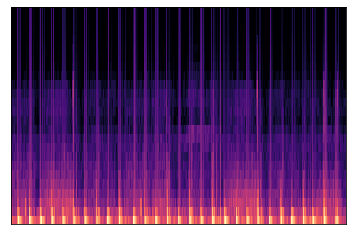

In [94]:
librosa.display.specshow(x_train[0])

# Aumentação de dados: SpecAugment

In [227]:
np.unique(y_train, return_counts=True)

(array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia',
        'URTI'], dtype='<U14'), array([  49,  114, 4303,  184,  147,  175]))

### Mascaramento de frequência

In [279]:
def frequency_masking(x, y, class_, n_mask, param):
  #x: conjunto de amostras originais 
  #y: classes originais
  #class_: classe em que as amostras devem ser aumentadas
  #n_mask: quantidade de mascaras
  #param: o mascaramento é escolhido aleatoriamente entre uma distribuição uniforme entre 0 e param
  augmented_espectrograms = []
  augmented_class = []
  for i in range(len(class_)):
    for j in range(len(y)):
      mask = n_mask
      if y[j] == class_[i]:
        if mask > 0:
          freq_mask = tfio.experimental.audio.freq_mask(x[j], param= param)
          mask -= 1
          while mask > 0:
            freq_mask = tfio.experimental.audio.freq_mask(freq_mask, param= param)
            mask -= 1
          augmented_espectrograms.append(freq_mask.numpy())
          augmented_class.append(y[j])
  return augmented_espectrograms,augmented_class            #retorna somente as amostras aumentadas

In [280]:
x_fm3,y_fm3 = frequency_masking(x_train, y_train, ['Bronchiectasis','Bronchiolitis', 'Healthy', 'Pneumonia', 'URTI'], 3, 30)
x_fm4,y_fm4 = frequency_masking(x_train, y_train, ['Bronchiectasis','Bronchiolitis', 'Healthy', 'Pneumonia', 'URTI'], 4, 30)

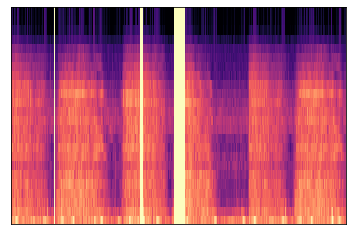

In [281]:
librosa.display.specshow(x_fm3[0])

### Mascaramento de tempo

In [283]:
def time_masking(x, y, class_, n_mask, param):
  #x: conjunto de amostras originais 
  #y: classes originais
  #class_: classe em que as amostras devem ser aumentadas
  #n_mask: quantidade de mascaras
  #param: o mascaramento é escolhido aleatoriamente entre uma distribuição uniforme entre 0 e param
  augmented_espectrograms = []
  augmented_class = []
  for i in range(len(class_)):
    for j in range(len(y)):
      mask = n_mask
      if y[j] == class_[i]:
        if mask > 0:
          time_mask = tfio.experimental.audio.time_mask(x[j], param= param)
          mask -= 1
          while mask > 0:
            time_mask = tfio.experimental.audio.time_mask(time_mask, param= param)
            mask -= 1
          augmented_espectrograms.append(time_mask.numpy())
          augmented_class.append(y[j])
  return augmented_espectrograms,augmented_class            #retorna somente as amostras aumentadas

In [284]:
x_tm2,y_tm2 = time_masking(x_train, y_train, ['Bronchiectasis','Bronchiolitis', 'Healthy', 'Pneumonia','URTI'], 2, 6)
x_tm3,y_tm3 = time_masking(x_train, y_train, ['Bronchiectasis','Bronchiolitis', 'Healthy', 'Pneumonia','URTI'], 3, 6)

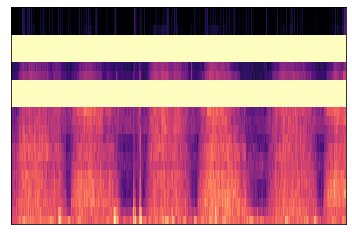

In [289]:
librosa.display.specshow(x_tm2[3])

### Mascaramento de frequência e tempo

In [290]:
x_ftm2,y_ftm2 = time_masking(x_fm3, y_fm3, ['Bronchiectasis','Bronchiolitis', 'Healthy', 'Pneumonia','URTI'], 2, 6)
x_ftm3,y_ftm3 = time_masking(x_fm3, y_fm3, ['Bronchiectasis','Bronchiolitis', 'Healthy', 'Pneumonia','URTI'], 3, 6)

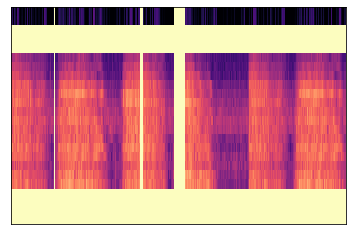

In [291]:
librosa.display.specshow(x_ftm2[0])

In [292]:
x_augmented = []
y_augmented = []
#Amostras originais
for i in range(len(y_train)):
  x_augmented.append(x_train[i])
  y_augmented.append(y_train[i])
# Amostras com mascaramento de frequência
for i in range(len(y_fm3)):
  x_augmented.append(x_fm3[i])
  y_augmented.append(y_fm3[i])
for i in range(len(y_fm4)):
  x_augmented.append(x_fm4[i])
  y_augmented.append(y_fm4[i])
# Amostras com mascaramento de tempo
for i in range(len(y_tm2)):
  x_augmented.append(x_tm2[i])
  y_augmented.append(y_tm2[i])
for i in range(len(y_tm3)):
  x_augmented.append(x_tm3[i])
  y_augmented.append(y_tm3[i])
# Amostras com mascaramento de frequência e tempo
for i in range(len(y_ftm2)):
  x_augmented.append(x_ftm2[i])
  y_augmented.append(y_ftm2[i])
for i in range(len(y_ftm3)):
  x_augmented.append(x_ftm3[i])
  y_augmented.append(y_ftm3[i])

print(np.shape(x_augmented))
print(np.shape(y_augmented))

(8986, 24, 438)
(8986,)


In [293]:
np.unique(y_augmented,return_counts=True)

(array(['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia',
        'URTI'], dtype='<U14'), array([ 343,  798, 4303, 1288, 1029, 1225]))

# Pré processamento de imagem

### Normalização

In [296]:
x_train = (x_augmented - np.min(x_augmented))/(np.max(x_augmented) - np.min(x_augmented))
x_test = (x_test - np.min(x_test))/(np.max(x_test) - np.min(x_test))
x_val = (x_val - np.min(x_val))/(np.max(x_val) - np.min(x_val))

### Expandir dimensão 

In [297]:
x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)
x_val = np.expand_dims(x_val, axis = 3)

In [311]:
np.shape(x_train)

(8986, 24, 438, 1)

### Label encoder

In [301]:
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_augmented)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [302]:
np.unique(y_train)
list(le.classes_)

['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

# Extrator de características

## Rede siamesa com triplet loss online semi-hard

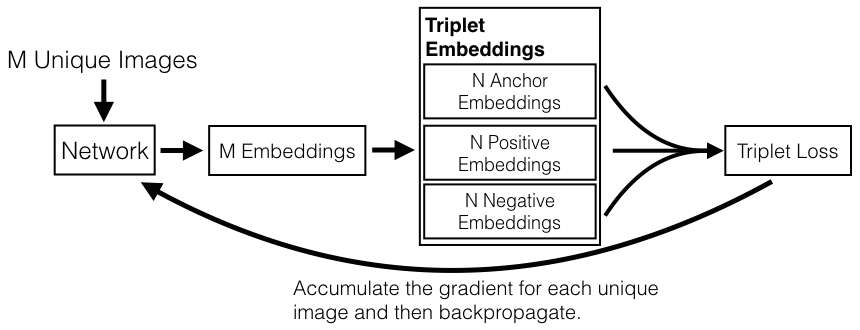

In [9]:
def minibatch_generator(x_set,y_set, sample_per_class):
  # x_set: amostras
  # y_set: rótulos
  # sample_per_class: quantidade de amostras por classe
  while True:
    classes = len(y_set)
    mini_batch = []
    labels = []
    cont_0 = 0
    cont_1 = 0
    cont_2 = 0
    cont_3 = 0
    cont_4 = 0
    cont_5 = 0
    while len(mini_batch) < sample_per_class* len(np.unique(y_set)):
      sample = np.random.randint(classes)
      if (cont_0 < sample_per_class) and (y_set[sample]==0) :
        mini_batch.append(x_set[sample])
        labels.append(y_set[sample])
        cont_0 += 1
      elif (cont_1 < sample_per_class) and (y_set[sample]==1):
        mini_batch.append(x_set[sample])
        labels.append(y_set[sample])
        cont_1 += 1
      elif (cont_2 < sample_per_class) and (y_set[sample]==2):
        mini_batch.append(x_set[sample])
        labels.append(y_set[sample])
        cont_2 += 1
      elif (cont_3 < sample_per_class) and (y_set[sample]==3):
        mini_batch.append(x_set[sample])
        labels.append(y_set[sample])
        cont_3 += 1
      elif (cont_4 < sample_per_class) and (y_set[sample]==4):
        mini_batch.append(x_set[sample])
        labels.append(y_set[sample])
        cont_4 += 1
      elif (cont_5 < sample_per_class) and (y_set[sample]==5):
        mini_batch.append(x_set[sample])
        labels.append(y_set[sample])
        cont_5 += 1
    mini_batch = np.array(mini_batch, dtype="float32")
    yield mini_batch,np.array(labels)

In [10]:
def embedding_model_online():
  model = Sequential()

  model.add(Convolution2D(64, (2,2), padding = 'same', activation='relu', input_shape=(np.shape(x_train)[1],np.shape(x_train)[2],1), name="conv1_embedding"))
  model.add(MaxPooling2D(pool_size=(2,2),name = "maxpool_1"))
  model.add(Dropout(0.3,name = "dropout_1"))

  model.add(Convolution2D(32, (2,2), padding = 'same', activation='relu', name = 'conv_2'))
  model.add(MaxPooling2D(pool_size=(2,2),name = "maxpool_2"))
  model.add(Dropout(0.3,name = "dropout_2"))

  model.add(Flatten(name = "flatten_1"))
  model.add(Dense(128, activation=None))
  model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
  return model

In [11]:
sample_per_class = 5
train_generator = minibatch_generator(x_train,y_train,sample_per_class)
validation_generator = minibatch_generator(x_val,y_val,sample_per_class)
test_generator = minibatch_generator(x_test,y_test,sample_per_class)

In [12]:
batch_size = sample_per_class * len(np.unique(y_train))
patience = 10
epochs = 100

In [13]:
embedding_model_online = embedding_model_online()
embedding_model_online.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tfa.losses.TripletSemiHardLoss(0.2))
es = EarlyStopping(monitor='val_loss', patience=patience,verbose=2,mode='min', restore_best_weights=True)
history = embedding_model_online.fit_generator(generator = train_generator, 
                                                validation_data = validation_generator, 
                                                steps_per_epoch = len(y_train) // batch_size,
                                                validation_steps= len(y_val) // batch_size,
                                                epochs=epochs,
                                                verbose = 1,
                                                callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
299/299 [==============================] - 43s 30ms/step - loss: 0.1496 - val_loss: 0.1619
Epoch 2/100
299/299 [==============================] - 9s 29ms/step - loss: 0.1308 - val_loss: 0.1350
Epoch 3/100
299/299 [==============================] - 9s 30ms/step - loss: 0.1258 - val_loss: 0.1298
Epoch 4/100
299/299 [==============================] - 9s 29ms/step - loss: 0.1230 - val_loss: 0.1364
Epoch 5/100
299/299 [==============================] - 8s 28ms/step - loss: 0.1178 - val_loss: 0.1346
Epoch 6/100
299/299 [==============================] - 9s 29ms/step - loss: 0.1130 - val_loss: 0.1396
Epoch 7/100
299/299 [==============================] - 9s 30ms/step - loss: 0.1067 - val_loss: 0.1414
Epoch 8/100
299/299 [==============================] - 9s 29ms/step - loss: 0.0982 - val_loss: 0.1390
Epoch 9/100
299/299 [==============================] - 9s 29ms/step - loss: 0.0906 - val_loss: 0.1391
Epoch 10/100
299/299 [==============================] - 9s 29ms/step - loss: 0.07

## Rede siamesa com triplet loss offline

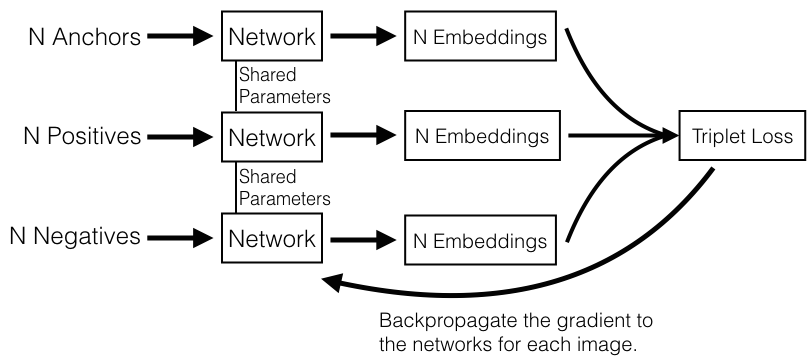

In [15]:
def get_image(x_set,y_set,label):
    y = y_set 
    x = x_set
    idx = np.random.randint(len(y))
    while y[idx] != label:
        idx = np.random.randint(len(y)) 
    return x[idx]

def get_triplet(x_set,y_set):
    classes = len(np.unique(y_set))
    negative = anchor = np.random.randint(classes) #choose an anchor
    while negative == anchor:
        negative = np.random.randint(classes) #get a negative
    anchor, positive = get_image(x_set, y_set, anchor), get_image(x_set, y_set, anchor)
    negative = get_image(x_set, y_set, negative)
    return anchor, positive, negative

#Gerador de triplets
def triplets_generator(x_set,y_set):
  # x_set: amostras
  # y_set: rótulos
  while True:
      list_anchor = []
      list_positive = []
      list_negative = []

      for i in range(batch_size):
          anchor, positive, negative = get_triplet(x_set,y_set)
          list_anchor.append(anchor)
          list_positive.append(positive)
          list_negative.append(negative)
            
      A = np.array(list_anchor, dtype='float32')
      P = np.array(list_positive, dtype='float32')
      N = np.array(list_negative, dtype='float32')
      label = np.ones(batch_size)
      yield [A, P, N], label


In [16]:
#Função da triplet loss
def identity_loss(y_true, y_pred):
    return K.cast(K.mean(y_pred), dtype='float64')

def triplet_loss(inputs, alpha=0.2):
    anchor,positive,negative = inputs
    positive_distance = K.sqrt(K.sum(K.square(anchor-positive),axis=1))
    negative_distance = K.sqrt(K.sum(K.square(anchor-negative),axis=1))
    basic_loss = positive_distance - negative_distance + alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [17]:
def embedding_model_offline():
  model = Sequential()

  model.add(Convolution2D(64, (2,2), padding = 'same', activation='relu', input_shape=(np.shape(x_train)[1],np.shape(x_train)[2],1), name="conv1_embedding"))
  model.add(MaxPooling2D(pool_size=(2,2),name = "maxpool_1"))
  model.add(Dropout(0.3,name = "dropout_1"))

  model.add(Convolution2D(32, (2,2), padding = 'same', activation='relu', name = 'conv_2'))
  model.add(MaxPooling2D(pool_size=(2,2),name = "maxpool_2"))
  model.add(Dropout(0.3,name = "dropout_2"))

  model.add(Flatten(name = "flatten_1"))
  model.add(Dense(128, activation=None))
  model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))
  return model

def complete_model(base_model):
    input_1 = Input((np.shape(x_train)[1],np.shape(x_train)[2],1), name = "anchor")
    input_2 = Input((np.shape(x_train)[1],np.shape(x_train)[2],1), name = "positive")
    input_3 = Input((np.shape(x_train)[1],np.shape(x_train)[2],1), name = "negative")
        
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)

    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    return model

In [18]:
batch_size = 4
patience = 10
epochs = 100

In [19]:
train_generator = triplets_generator(x_train,y_train)
test_generator = triplets_generator(x_test,y_test)
validation_generator = triplets_generator(x_val,y_val)

In [20]:
embedding_model_offline = embedding_model_offline()
complete_embedding_model_offline = complete_model(embedding_model_offline)
complete_embedding_model_offline.compile(loss=identity_loss, optimizer=Adam(0.001))
es = EarlyStopping(monitor='val_loss', patience=patience,verbose=2,mode='min', restore_best_weights=True)
history = complete_embedding_model_offline.fit_generator(generator = train_generator, 
                                                validation_data = validation_generator, 
                                                steps_per_epoch = len(y_train) // batch_size,
                                                validation_steps= len(y_val) // batch_size,
                                                epochs=epochs,
                                                verbose = 1,
                                                callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
2246/2246 [==============================] - 23s 10ms/step - loss: 0.1815 - val_loss: 0.1623
Epoch 2/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.1557 - val_loss: 0.1593
Epoch 3/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.1285 - val_loss: 0.1523
Epoch 4/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.1066 - val_loss: 0.1777
Epoch 5/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.0860 - val_loss: 0.1677
Epoch 6/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.0722 - val_loss: 0.1681
Epoch 7/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.0613 - val_loss: 0.1789
Epoch 8/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.0502 - val_loss: 0.1659
Epoch 9/100
2246/2246 [==============================] - 22s 10ms/step - loss: 0.0426 - val_loss: 0.1752
Epoch 10/100
2246/2246 [==============================]

# Classificador: K-nn

In [26]:
X_train_online = embedding_model_online.predict(x_train)
X_test_online = embedding_model_online.predict(x_test)

X_train_offline = embedding_model_offline.predict(x_train)
X_test_offline = embedding_model_offline.predict(x_test)


## Classificação das características extraídas online

In [45]:
knn = KNeighborsClassifier(n_neighbors=4, weights = 'distance', metric = 'euclidean')
knn.fit(X_train_online, y_train)
y_pred = knn.predict(X_test_online)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))  
print("Acurácia kNN:", accuracy_score(y_test, y_pred))

[[  0   2  35   0   0   4]
 [  0   2  21   0   1   3]
 [  3   8 393   7   4  11]
 [  0   0  25   1   6   0]
 [  0   0  25   0   1   0]
 [  0   5  19   0   0   2]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.12      0.07      0.09        27
           2       0.76      0.92      0.83       426
           3       0.12      0.03      0.05        32
           4       0.08      0.04      0.05        26
           5       0.10      0.08      0.09        26

    accuracy                           0.69       578
   macro avg       0.20      0.19      0.19       578
weighted avg       0.58      0.69      0.63       578

Acurácia kNN: 0.6903114186851211


## Classificação das características extraídas offline

In [53]:
knn = KNeighborsClassifier(n_neighbors=2, weights = 'distance', metric = 'euclidean')
knn.fit(X_train_offline, y_train)
y_pred = knn.predict(X_test_offline)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))  
print("Acurácia kNN:", accuracy_score(y_test, y_pred))

[[  1   0  33   2   1   4]
 [  0   0  21   4   0   2]
 [  0  12 353  24  21  16]
 [  0   0  24   5   3   0]
 [  0   0  21   0   5   0]
 [  0   2  19   2   0   3]]
              precision    recall  f1-score   support

           0       1.00      0.02      0.05        41
           1       0.00      0.00      0.00        27
           2       0.75      0.83      0.79       426
           3       0.14      0.16      0.14        32
           4       0.17      0.19      0.18        26
           5       0.12      0.12      0.12        26

    accuracy                           0.63       578
   macro avg       0.36      0.22      0.21       578
weighted avg       0.64      0.63      0.60       578

Acurácia kNN: 0.6349480968858131
